<a href="https://colab.research.google.com/github/jasmineA20/435-deep-learning/blob/main/Jet_Tagging_with_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install fastai==2.6.0 datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.8/188.8 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 53.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from datasets import load_dataset
from fastai.callback.hook import *
from fastai.vision.all import *
from sklearn.metrics import accuracy_score
from torch.utils.data import TensorDataset
from torchvision.transforms import ToTensor

In [3]:
import datasets

# Suppress logs to keep things tidy
datasets.logging.set_verbosity_error()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1211000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/403000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/404000 [00:00<?, ? examples/s]

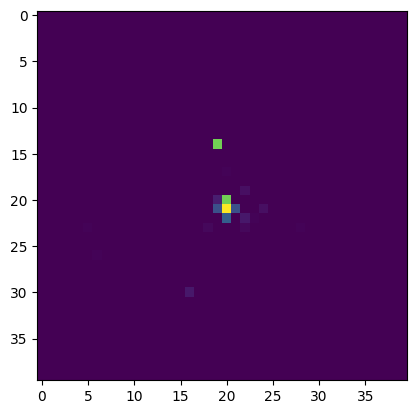

In [4]:
images_ds = load_dataset("dl4phys/top_tagging_images")

# Peek at one example
plt.imshow(images_ds["train"][0]["image"]);

In [5]:
def get_dataset(dataset, num_examples=None):
    if num_examples is not None:
        dataset = dataset.shuffle(seed=42).select(range(num_examples))

    x = torch.cat([ToTensor()(img) for img in dataset["image"]]).unsqueeze(1)
    y = torch.cat([torch.tensor(l).unsqueeze(0) for l in dataset["label"]])

    return TensorDataset(x, y)

In [6]:
# Lower the training size if Colab RAM explodes 💣
train_ds = get_dataset(images_ds["train"], num_examples=350_000)
valid_ds = get_dataset(images_ds["validation"], num_examples=35_000)

In [7]:
def get_dls(bs=128):
    train_dl = DataLoader(train_ds, bs=bs, shuffle=True)
    valid_dl = DataLoader(valid_ds, bs=bs)
    return DataLoaders(train_dl, valid_dl)

In [8]:
dls = get_dls()

xb, yb = first(dls.train)
xb.shape, yb.shape

(torch.Size([128, 1, 40, 40]), torch.Size([128]))

Creating a CNN


In [9]:
model = nn.Sequential(
    nn.Linear(20, 200),
    nn.ReLU(),
    nn.Linear(200, 2),
)

model

Sequential(
  (0): Linear(in_features=20, out_features=200, bias=True)
  (1): ReLU()
  (2): Linear(in_features=200, out_features=2, bias=True)
)

In [13]:
broken_cnn = nn.Sequential(
    nn.Conv2d(1, 30, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(30, 1, kernel_size=3, padding=1),
)

In [14]:
# Feed a minibatch to the model
outputs = broken_cnn(xb)
outputs.shape

torch.Size([128, 1, 40, 40])

In [15]:
torch.Size([128, 1, 40, 40])

torch.Size([128, 1, 40, 40])

In [16]:
def conv(ni, nf, ks=3, act=True):
    layer = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks // 2)
    if act:
        layer = nn.Sequential(layer, nn.ReLU())
    return layer

In [17]:
simple_cnn = nn.Sequential(
    conv(1, 4),  # 20x20
    conv(4, 8),  # 10x10
    conv(8, 16),  # 5x5
    conv(16, 32),  # 3x3
    conv(32, 16),  # 2x2
    conv(16, 2, act=False),  # 1x1
    Flatten(),
)

learn = Learner(
    dls, simple_cnn, metrics=[accuracy, RocAucBinary()], loss_func=F.cross_entropy
)
learn.summary()

Sequential (Input shape: 128 x 1 x 40 x 40)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 4 x 20 x 20   
Conv2d                                    40         True      
ReLU                                                           
____________________________________________________________________________
                     128 x 8 x 10 x 10   
Conv2d                                    296        True      
ReLU                                                           
____________________________________________________________________________
                     128 x 16 x 5 x 5    
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     128 x 32 x 3 x 3    
Conv2d                                    4640       True      
ReLU                                         

In [18]:
simple_cnn(xb).shape

torch.Size([128, 2])

In [19]:
torch.Size([128, 2])

torch.Size([128, 2])

SuggestedLRs(valley=0.007585775572806597)

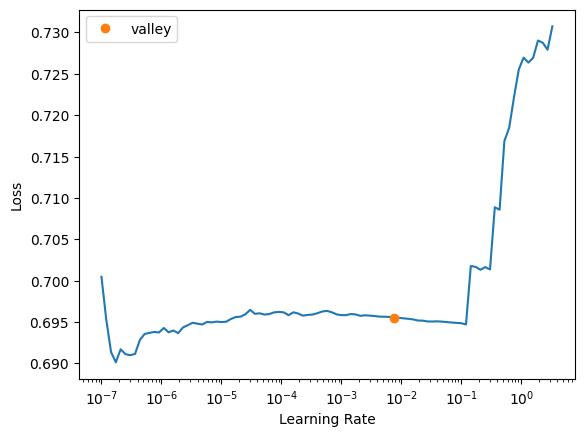

In [20]:
learn.lr_find()

In [22]:
learn.fit(3, 3e-3)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.254970,0.256068,0.893857,0.959272,00:50
1,0.244106,0.257060,0.895257,0.961333,00:50
2,0.234205,0.241073,0.899371,0.963153,00:49
